### This notebook explores how to access and examine data from the LEN dataset.
The main requirements are rasterio and geopandas.  
LEN_STAC repo is used to search catalog.  
geemap is used to create a map GUI and create an AOI extent from the map.  
pytz and timezonefinder are used to convert time zones.

In [1]:
import sys, os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show

#earth engine
import geemap
import ee
from geemap.conversion import *

sys.path.append(os.path.join(os.path.expanduser("~"), "Repos", "LEN_STAC", "src"))
from len_tools import Catalog

#timezone
from timezonefinder import TimezoneFinder
import pytz

# mapping stuff
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

In [2]:
%load_ext autoreload
%autoreload 2

### Prepare AOI and load catalog

In [3]:
ee.Initialize()

In [4]:
pac_path = 'C:/Users/wb514197/OneDrive - WBG/Pacific Observatory/Data'
pac_adm0 = gpd.read_file(os.path.join(pac_path, "Adm0_Pacific.shp"))

In [5]:
png = pac_adm0.loc[pac_adm0.ISO3=="PNG"].copy()
png = png.to_crs('EPSG:4326')
cent = png.geometry.representative_point().iloc[0]

In [6]:
zoomlevel = 8
# initialize our map
Map = geemap.Map(center=[cent.y, cent.x], zoom=zoomlevel)
Map.addLayerControl()

We create a map to draw a bounding box around Port Moresby.

In [7]:
Map

Map(center=[-6.656580539029349, 144.3519772274074], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
# capture geojson of drawn feature
aoi_ee = ee.FeatureCollection(Map.draw_features)
aoi_ee.getInfo()

{'type': 'FeatureCollection',
 'columns': {'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'geodesic': False,
    'type': 'Polygon',
    'coordinates': [[[147.05816, -9.58796],
      [147.05816, -9.321775],
      [147.341791, -9.321775],
      [147.341791, -9.58796],
      [147.05816, -9.58796]]]},
   'id': '0',
   'properties': {}}]}

In [9]:
aoi = ee_to_geopandas(aoi_ee)
aoi.set_crs(epsg=4326, inplace = True)

,geometry
0,"POLYGON ((147.05816 -9.58796, 147.05816 -9.32178, 147.34179 -9.32178, 147.34179 -9.58796, 147.05816 -9.58796))"


In [10]:
%%time
cat = Catalog()

Wall time: 51.5 s


In [11]:
print(cat)

Catalog with 396262 scenes


In [12]:
# res = cat.search_by_year_month(2020, 10)
# res = cat.search_by_day("2020-05-05")
# get 10 days of data
res = cat.search_by_period("2020-05-01", "2020-05-10")

In [13]:
print(res)

Catalog with 1201 scenes


In [14]:
res = res.search_by_intersect(aoi)

In [15]:
print(res)

Catalog with 18 scenes


### Convert UTC to local time zone

In [16]:
tf = TimezoneFinder()
tz = tf.timezone_at(lng=cent.x, lat=cent.y)
timezone = pytz.timezone(tz)

In [18]:
timezone

<DstTzInfo 'Pacific/Port_Moresby' LMT+9:49:00 STD>

In [19]:
for idx, scene in res.scenes.iterrows():
    res.scenes.loc[idx, "datetime"] = scene.datetime.tz_convert(timezone)

### Examine one scene

In [23]:
scene = res.scenes.iloc[0]

In [24]:
scene.datetime

Timestamp('2020-05-02 00:56:07+1000', tz='Pacific/Port_Moresby')

In [25]:
href = scene.href
cur_tif = rio.open(href)

In [26]:
geometry = aoi.geometry.iloc[0]

In [27]:
ul = cur_tif.index(*geometry.bounds[0:2])
lr = cur_tif.index(*geometry.bounds[2:4])
window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))

In [28]:
data = cur_tif.read(1, window = window)

In [29]:
data[data<0]

array([], dtype=float32)

In [30]:
data.min(), data.max()

(0.34785166, 11.021942)

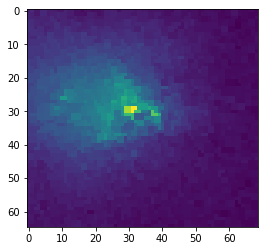

<AxesSubplot:>

In [31]:
show(data)

### Make a plot of radiance with each daily scene

In [21]:
res.scenes.reset_index(drop=True, inplace=True)

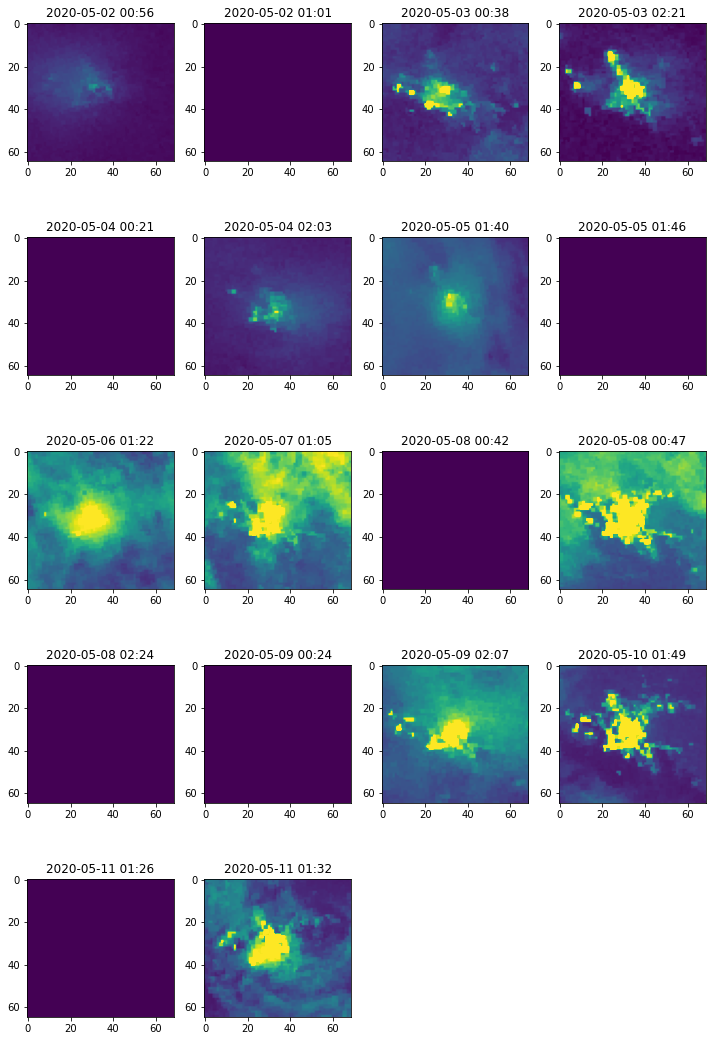

In [66]:
fig = plt.figure(figsize=(10, 15))

for i, scene in res.scenes.iterrows():
    i = i+1
#     print(scene.datetime)
    href = scene.href
    cur_tif = rio.open(href)
    ul = cur_tif.index(*geometry.bounds[0:2])
    lr = cur_tif.index(*geometry.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    data = cur_tif.read(1, window = window)
    date_format = scene.datetime.strftime("%Y-%m-%d %H:%M")
    ax = fig.add_subplot(5,4,i)
    ax.set_title(f"{date_format}")
    show(data, vmin=0, vmax=20, ax=ax)

plt.tight_layout()

### Look at quality data (VFLAG)

In [67]:
href

'https://globalnightlight.s3.amazonaws.com/npp_202005/SVDNB_npp_d20200510_t1532046_e1537449_b44226_c20200510193746165682_noac_ops.rade9.co.tif'

In [68]:
s = href.replace('SVDNB_', '')
s = s.split("_")
s = "_".join(s[0:-3])+'.vflag.co.tif'

In [69]:
cur_tif = rio.open(s)

In [70]:
vflag = cur_tif.read(1, window = window)

In [71]:
flags = np.unique(vflag)

In [72]:
flags

array([1044054147, 1044054155, 1044054163], dtype=uint32)

Try to figure out what this value means. Bit-flag descriptions are provided here: https://worldbank.github.io/OpenNightLights/wb-light-every-night-readme.html#

In [73]:
flag = np.binary_repr(flags[0], width=32)

In [74]:
len(flag)

32

In [75]:
flag

'00111110001110110000000010000011'

In [76]:
flag[-3] # flag pos 2. 
#0 good quality
#1 bad

'0'

In [77]:
flag[-5]+flag[-4] # flag pos 3 and 4. 
#00 Clear sky (0)
#01 Probably cloudy (1)
#10 Confidently cloudy (2)
#11 Clouds unknown (3)

'00'

In [78]:
flag[-6] # flag pos 5. 
#0 Yes moonlight?
#1 No Moonlight

'0'

In [79]:
flag[-8]+flag[-7] # flag pos 6. and 7.
#00 Day time
#01 Terminator (between day and night)
#10 Night
#11 Uknown

'10'

In [80]:
flag[-15]+flag[16] # flag pos 14. and 15.
#00 No Stray light
#01 Stray light impact
#10 Stray light correction
#11 Stray light impact and correction

'00'

In [81]:
flag[-23]+flag[-24] # flag pos 22. and 23.
#00 No lightning
#01 Lightning
#10 Spare value?
#11 No data

'00'

In [82]:
flag[-25] # flag pos 24
# 0 
# 1 High energy particle

'0'

In [83]:
flag[-32] # flag pos 31
# 0
# 1 no data for that scanline

'0'

Look at cloud flag (position 3, and 4)  
The << operator shifts a value three spaces to the left.

In [84]:
clear_BitMask = np.binary_repr(0 << 3)
probCloudy_BitMask = np.binary_repr(1 << 3)
confCloudy_BitMask = np.binary_repr(2 << 3)
uknown_BitMask = np.binary_repr(3 << 3)

In [85]:
clear_BitMask, probCloudy_BitMask, confCloudy_BitMask, uknown_BitMask

('0', '1000', '10000', '11000')

In [86]:
clear_BitMask = (0 << 3)
probCloudy_BitMask = (1 << 3)
confCloudy_BitMask = (2 << 3)
uknown_BitMask = (3 << 3)

Check what the result of and operator is

In [87]:
uknown = np.bitwise_and(vflag, uknown_BitMask)
prob = np.bitwise_and(vflag, probCloudy_BitMask)
conf = np.bitwise_and(vflag, confCloudy_BitMask)

In [88]:
int('11000', 2)

24

In [89]:
(uknown>=24) 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [90]:
np.unique(prob)

array([0, 8], dtype=uint32)

In [91]:
np.binary_repr(8)

'1000'

In [92]:
np.unique(conf)

array([ 0, 16], dtype=uint32)

In [93]:
np.binary_repr(16)

'10000'

In [94]:
prob = np.bitwise_and(vflag, probCloudy_BitMask).astype('bool')
conf = np.bitwise_and(vflag, confCloudy_BitMask).astype('bool')
uknown = np.bitwise_and(vflag, uknown_BitMask) #.astype('bool')
uknown = (uknown>=24)

In [95]:
vflag_decoded = vflag.copy()
vflag_decoded[:] = 0
vflag_decoded[prob] = 1
vflag_decoded[conf] = 2
vflag_decoded[uknown] = 3

In [96]:
vflag_decoded

array([[1, 2, 2, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0],
       [1, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [1, 0, 0, ..., 2, 2, 2],
       [1, 0, 0, ..., 2, 2, 2]], dtype=uint32)

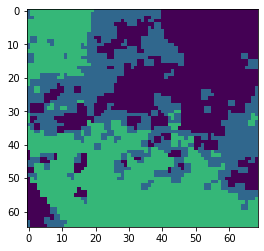

<AxesSubplot:>

In [97]:
show(vflag_decoded, vmin=0, vmax=3)

In [98]:
cmap = ListedColormap(["white", "lightblue", "darkblue", "black"])
norm = colors.BoundaryNorm([0, 1, 2, 3], 4)
legend_labels = {
    "white":'Clear', 
    "lightblue": "Probably Clouds", 
    "darkblue": "Confidently Clouds", 
    "black": "Uknown"
}

In [99]:
norm = colors.BoundaryNorm([0, 1, 2, 3, 4], 4)

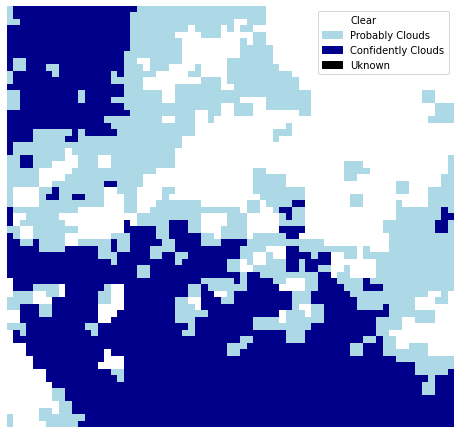

In [100]:
fig, ax = plt.subplots(1, 1,  figsize = (8, 8))
im = ax.imshow(vflag_decoded, cmap=cmap, norm=norm)

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

ax.legend(handles=patches) 

ax.set_axis_off()
plt.show()

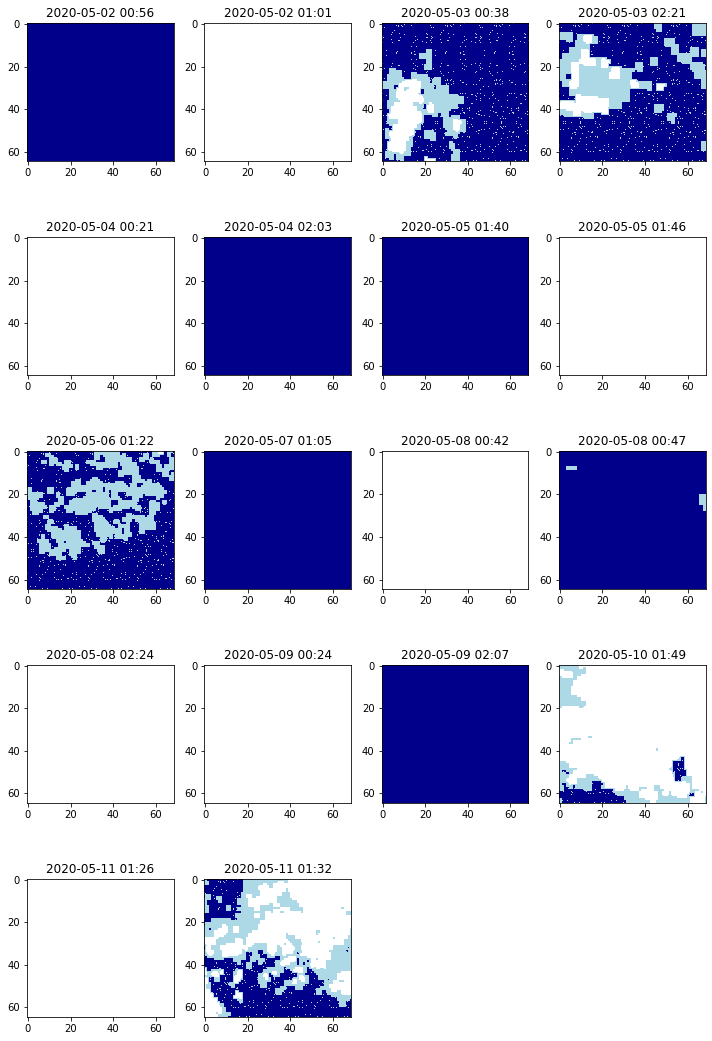

In [101]:
fig = plt.figure(figsize=(10, 15))

for i, scene in res.scenes.iterrows():
    i = i+1
    href = scene.href
    s = href.replace('SVDNB_', '')
    s = s.split("_")
    s = "_".join(s[0:-3])+'.vflag.co.tif'
    cur_tif = rio.open(s)
    ul = cur_tif.index(*geometry.bounds[0:2])
    lr = cur_tif.index(*geometry.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    
    vflag = cur_tif.read(1, window = window)
    prob = np.bitwise_and(vflag, probCloudy_BitMask).astype('bool')
    conf = np.bitwise_and(vflag, confCloudy_BitMask).astype('bool')
    uknown = np.bitwise_and(vflag, uknown_BitMask) #.astype('bool')
    uknown = (uknown>=24)
    vflag_decoded = vflag.copy()
    vflag_decoded[:] = 0
    vflag_decoded[prob] = 1
    vflag_decoded[conf] = 2
    vflag_decoded[uknown] = 3
    
    date_format = scene.datetime.strftime("%Y-%m-%d %H:%M")
    ax = fig.add_subplot(5,4,i)
    ax.set_title(f"{date_format}")
    im = ax.imshow(vflag_decoded, cmap=cmap, norm=norm)

plt.tight_layout()